# ESOL

This Notebook uses the RDKit, ChemProp, and Delaney Dataset for ESOL.

Results are compared to MoleculeNet Paper (https://doi.org/10.1039/C7SC02664A)

Author: James Roberts

# Imports

In [31]:
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem

from chemprop import data, featurizers, models, nn

from lightning import pytorch as pl
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks import EarlyStopping

import pandas as pd
import numpy as np

import requests

from itertools import product

import torch
import torch.nn.functional as F
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
from torch_geometric.nn import GraphConv, NNConv, TransformerConv
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data, Batch
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns

import matplotlib.pyplot as plt

import random

# Importing molecules using SMILES

Acetaminophen SMILES representation: CC(=O)NC1=CC=C(O)C=C1

drugbank: https://go.drugbank.com/drugs/DB00316

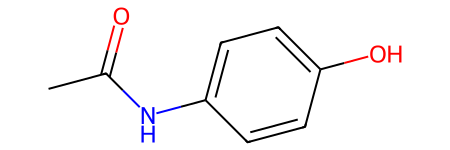

In [3]:
molecule = Chem.MolFromSmiles('CC(=O)NC1=CC=C(O)C=C1')
molecule

# Importing molecules using MOL

Acetaminophen MOL

pubchem: https://pubchem.ncbi.nlm.nih.gov/

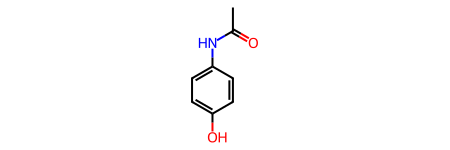

In [4]:
molecule_url = "https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/CID/1983/SDF"
response = requests.get(molecule_url)
molecule = Chem.MolFromMolBlock(response.text)
molecule

# Molecular Coords

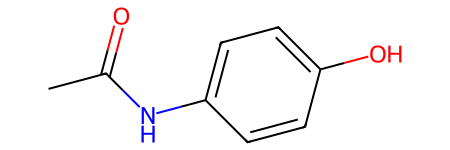

In [5]:
AllChem.Compute2DCoords(molecule)
molecule

# Descriptors

In [6]:
Descriptors.MolWt(molecule) # g/mol

151.16499999999996

In [7]:
print("LogP = log( [organic] / [aqueous] )")
print("LogP (RDkit, Predicted): ", Descriptors.MolLogP(molecule))
print("LogP (ALOGPS, Predicted): ", 0.51)
print("LogP (DrugBank, Measured): ", 0.46)

LogP = log( [organic] / [aqueous] )
LogP (RDkit, Predicted):  1.3505999999999998
LogP (ALOGPS, Predicted):  0.51
LogP (DrugBank, Measured):  0.46


# Delaney Dataset

From: https://moleculenet.org/datasets-1 (ESOL)

The task (Regression) is to predict the log solubility (mols/litre)

In [8]:
PATH_TO_DELANEY = 'https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/delaney-processed.csv'
delaney_dataset = pd.read_csv(PATH_TO_DELANEY)
delaney_dataset.head()

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.87,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.33,c1ccsc1


In [9]:
delaney_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1128 entries, 0 to 1127
Data columns (total 10 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   Compound ID                                      1128 non-null   object 
 1   ESOL predicted log solubility in mols per litre  1128 non-null   float64
 2   Minimum Degree                                   1128 non-null   int64  
 3   Molecular Weight                                 1128 non-null   float64
 4   Number of H-Bond Donors                          1128 non-null   int64  
 5   Number of Rings                                  1128 non-null   int64  
 6   Number of Rotatable Bonds                        1128 non-null   int64  
 7   Polar Surface Area                               1128 non-null   float64
 8   measured log solubility in mols per litre        1128 non-null   float64
 9   smiles                        

In [10]:
delaney_dataset.describe()

,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre
count,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000,1128.000000
mean,-2.988192,1.058511,203.937074,0.701241,1.390957,2.177305,34.872881,-3.050102
std,1.683220,0.238560,102.738077,1.089727,1.318286,2.640974,35.383593,2.096441
min,-9.702000,0.000000,16.043000,0.000000,0.000000,0.000000,0.000000,-11.600000
25%,-3.948250,1.000000,121.183000,0.000000,0.000000,0.000000,0.000000,-4.317500
50%,-2.870000,1.000000,182.179000,0.000000,1.000000,1.000000,26.300000,-2.860000
75%,-1.843750,1.000000,270.372000,1.000000,2.000000,3.000000,55.440000,-1.600000
max,1.091000,2.000000,780.949000,11.000000,8.000000,23.000000,268.680000,1.580000


Done!


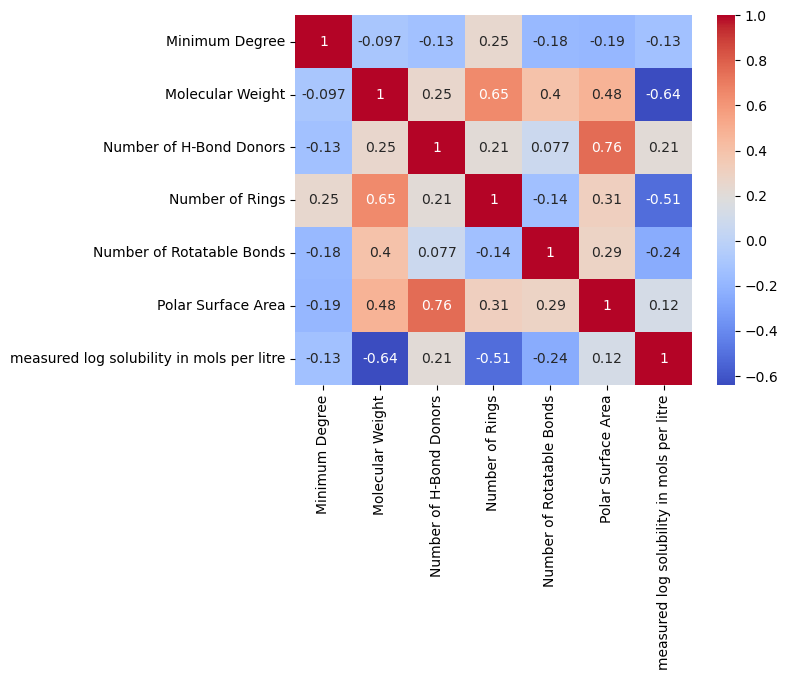

In [11]:
sns.heatmap(delaney_dataset.iloc[:, 2:9].corr(), annot=True, cmap='coolwarm')
print('Done!')

In [12]:
r2_ESOL = r2_score(delaney_dataset['ESOL predicted log solubility in mols per litre'], delaney_dataset['measured log solubility in mols per litre'])
print(f"ESOL R2: {r2_ESOL}")

ESOL R2: 0.707374251617849


## Preprocessing

In [13]:
def preprocess_delaney(delaney_dataset):
    # Split Data for normalization
    indices = list(range(len(delaney_dataset)))
    train_idx, temp_idx = train_test_split(indices, test_size=0.2, random_state=42)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)
    
    # Normalize global features based on training indices
    global_feats_train = delaney_dataset[[
        'Minimum Degree',
        'Number of H-Bond Donors',
        'Molecular Weight',
        'Number of Rings',
        'Number of Rotatable Bonds',
        'Polar Surface Area'
    ]].loc[train_idx].copy()
    
    scaler = MinMaxScaler()
    scaler.fit(global_feats_train)
    
    global_feats = delaney_dataset[[
        'Minimum Degree',
        'Number of H-Bond Donors',
        'Molecular Weight',
        'Number of Rings',
        'Number of Rotatable Bonds',
        'Polar Surface Area'
    ]].copy()
    
    normalized_feats = scaler.transform(global_feats)
    
    # Build Graphs
    print("Building Graphs")
    data_list_train = []
    data_list_test = []
    data_list_val = []
    index = 0
    atom_types = [1, 6, 8, 7, 9, 15, 16, 17, 35, 53] # Atoms used in delaney (Atomic Number)
    for compoundID in delaney_dataset['Compound ID']:
        mol = Chem.AddHs(Chem.MolFromSmiles(delaney_dataset.loc[index, 'smiles'])) 
        
        # Node features
        atom_features = []
        for atom in mol.GetAtoms():
            one_hot = [int(atom.GetAtomicNum() == t) for t in atom_types] # Atom OneHot
            
            # TODO: Normalize Atom Features
            other_features = [atom.GetAtomicNum(),
                              atom.GetDegree(),
                              atom.GetFormalCharge(),
                              int(atom.GetIsAromatic()),
                              int(atom.IsInRing()),
                              atom.GetMass()]
            
            atom_features.append(one_hot + other_features)
        
        # Edge index
        bond_features = []
        src = []
        dest = []
        for bond in mol.GetBonds():
            i = bond.GetBeginAtomIdx()
            j = bond.GetEndAtomIdx()
            src.append(i)
            src.append(j)
            dest.append(j)
            dest.append(i)
            bond_type = bond.GetBondType()
            
            bond_features.append([
                int(bond_type == Chem.rdchem.BondType.SINGLE),
                int(bond_type == Chem.rdchem.BondType.DOUBLE),
                int(bond_type == Chem.rdchem.BondType.TRIPLE),
                int(bond_type == Chem.rdchem.BondType.AROMATIC),
                int(bond.GetIsConjugated()),
                int(bond.IsInRing())
            ])
            bond_features.append(bond_features[-1])  # Add reverse direction
        edge_index = [src, dest]
    
        
        data = Data(x=torch.tensor(atom_features, dtype=torch.float), 
                    edge_index=torch.tensor(edge_index, dtype=torch.long),
                    edge_attr=torch.tensor(bond_features, dtype=torch.float),
                    y=torch.tensor([[delaney_dataset.loc[index, 'measured log solubility in mols per litre']]], dtype=torch.float))
        data.global_features = torch.tensor([normalized_feats[index] + [Descriptors.MolLogP(mol)]], dtype=torch.float)
        data.smiles = delaney_dataset.loc[index, 'smiles']
        data.ID = compoundID
    
        if index in train_idx:
            data_list_train.append(data)
        elif index in val_idx:
            data_list_val.append(data)
        else:
            data_list_test.append(data)
    
        index += 1
    
    # Training, validation, and test subsets follow 80/10/10 (MoleculeNet)
    train_batch = Batch.from_data_list(data_list_train) 
    val_batch = Batch.from_data_list(data_list_val)
    test_batch = Batch.from_data_list(data_list_test)

    return train_batch, val_batch, test_batch

print('Done!')

Done!


# Models

## GraphConv

In [14]:
class GraphConvRegr(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        in_channels = kwargs.get('in_channels')
        hidden_channels = kwargs.get('hidden_channels')
        out_channels = kwargs.get('out_channels')
        self.dropout = kwargs.get('dropout')
        num_layers = kwargs.get('num_layers')
        pooling_method = kwargs.get('pooling_method')
        num_global_features = kwargs.get('num_global_features')

        self.pooling = {"mean": pyg_nn.global_mean_pool,
                        "add" : pyg_nn.global_add_pool,
                        "max" : pyg_nn.global_max_pool}.get(pooling_method)

        # message-passing
        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()
        for i in range(num_layers):
            in_ch = in_channels if i == 0 else hidden_channels
            self.convs.append(GraphConv(in_ch, hidden_channels))
            self.batch_norms.append(torch.nn.BatchNorm1d(hidden_channels))

        # post-message-passing
        self.post_mp = torch.nn.Sequential(
        torch.nn.Linear(hidden_channels + num_global_features, hidden_channels),
        torch.nn.ReLU(),
        torch.nn.Dropout(self.dropout),
        torch.nn.Linear(hidden_channels, hidden_channels // 2),
        torch.nn.ReLU(),
        torch.nn.Dropout(self.dropout),
        torch.nn.Linear(hidden_channels // 2, out_channels)
        )

    def forward(self, batch):
        x = batch.x

        # Message passing through all layers
        for conv, bn in zip(self.convs, self.batch_norms):
            x = conv(x, batch.edge_index)
            x = bn(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.pooling(x, batch.batch)
        
        # Concatenate global features
        if hasattr(batch, 'global_features'):
            x = torch.cat([x, batch.global_features], dim=1)
            
        x = self.post_mp(x)
        return x

    def loss(self, pred, label):
        return F.mse_loss(pred, label)
        

## NNConv

In [15]:
class NNConvRegr(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        in_channels = kwargs.get('in_channels')
        hidden_channels = kwargs.get('hidden_channels')
        out_channels = kwargs.get('out_channels')
        edge_dim = kwargs.get('edge_dim')
        self.dropout = kwargs.get('dropout')
        num_layers = kwargs.get('num_layers')
        pooling_method = kwargs.get('pooling_method')
        num_global_features = kwargs.get('num_global_features')

        self.pooling = {"mean": pyg_nn.global_mean_pool,
                        "add" : pyg_nn.global_add_pool,
                        "max" : pyg_nn.global_max_pool}.get(pooling_method)

        # message-passing
        edge_mlp1 = torch.nn.Linear(edge_dim, in_channels * hidden_channels)
        edge_mlp2 = torch.nn.Linear(edge_dim, hidden_channels * hidden_channels)
        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()
        for i in range(num_layers):
            in_ch = in_channels if i == 0 else hidden_channels
            edge_mlp = edge_mlp1 if i == 0 else edge_mlp2
            self.convs.append(NNConv(in_ch, hidden_channels, nn=edge_mlp))
            self.batch_norms.append(torch.nn.BatchNorm1d(hidden_channels))

        # post-message-passing
        self.post_mp = torch.nn.Sequential(
        torch.nn.Linear(hidden_channels + num_global_features, hidden_channels),
        torch.nn.ReLU(),
        torch.nn.Dropout(self.dropout),
        torch.nn.Linear(hidden_channels, hidden_channels // 2),
        torch.nn.ReLU(),
        torch.nn.Dropout(self.dropout),
        torch.nn.Linear(hidden_channels // 2, out_channels)
        )

    def forward(self, batch):
        x = batch.x
        
        # Message passing through all layers
        for conv, bn in zip(self.convs, self.batch_norms):
            x = conv(x, batch.edge_index, batch.edge_attr)
            x = bn(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.pooling(x, batch.batch)

        # Concatenate global features
        if hasattr(batch, 'global_features'):
            x = torch.cat([x, batch.global_features], dim=1)
            
        x = self.post_mp(x)
        return x 

    def loss(self, pred, label):
        return F.mse_loss(pred, label)
        

## TransformerConv

In [16]:
class TransformerConvRegr(torch.nn.Module):
    def __init__(self, **kwargs):
        super().__init__()

        in_channels = kwargs.get('in_channels')
        hidden_channels = kwargs.get('hidden_channels')
        out_channels = kwargs.get('out_channels')
        edge_dim = kwargs.get('edge_dim')
        self.dropout = kwargs.get('dropout')
        num_layers = kwargs.get('num_layers')
        pooling_method = kwargs.get('pooling_method')
        num_global_features = kwargs.get('num_global_features')

        self.pooling = {"mean": pyg_nn.global_mean_pool,
                        "add" : pyg_nn.global_add_pool,
                        "max" : pyg_nn.global_max_pool}.get(pooling_method)

        # message-passing
        self.convs = torch.nn.ModuleList()
        self.batch_norms = torch.nn.ModuleList()
        for i in range(num_layers):
            in_ch = in_channels if i == 0 else hidden_channels
            self.convs.append(TransformerConv(in_ch, hidden_channels, edge_dim=edge_dim))
            self.batch_norms.append(torch.nn.BatchNorm1d(hidden_channels))

        # post-message-passing
        self.post_mp = torch.nn.Sequential(
        torch.nn.Linear(hidden_channels + num_global_features, hidden_channels),
        torch.nn.ReLU(),
        torch.nn.Dropout(self.dropout),
        torch.nn.Linear(hidden_channels, hidden_channels // 2),
        torch.nn.ReLU(),
        torch.nn.Dropout(self.dropout),
        torch.nn.Linear(hidden_channels // 2, out_channels)
        )

    def forward(self, batch):
        x = batch.x
        
        # Message passing through all layers
        for conv, bn in zip(self.convs, self.batch_norms):
            x = conv(x, batch.edge_index, batch.edge_attr)
            x = bn(x)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.pooling(x, batch.batch)

        # Concatenate global features
        if hasattr(batch, 'global_features'):
            x = torch.cat([x, batch.global_features], dim=1)
            
        x = self.post_mp(x)
        return x 

    def loss(self, pred, label):
        return F.mse_loss(pred, label)
        

# Training

In [18]:
def train(Model,
          train_dataset,
          val_dataset,
          test_dataset,
          epochs=200,
          batch_size=64,
          pooling_method="mean",
          early_stopping_patience=5,
          hidden_channels=32,
          in_channels=1,
          num_layers=3,
          verbose=True):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)
        
    model = Model(
        in_channels=in_channels,                        
        hidden_channels=hidden_channels,                
        out_channels=1,                                 
        edge_dim=train_dataset[0].edge_attr.size()[1],  
        dropout=0.25,
        pooling_method=pooling_method,
        num_layers=num_layers,
        num_global_features=train_dataset[0].global_features.shape[1]
    )
    
    
    opt = optim.Adam(model.parameters(), lr=0.001)
    
    best_avg_loss = None
    best_r2 = None
    patience = 0
    best_epoch = 0
    # train
    print("Training Starting")
    
    for epoch in range(epochs):
        total_loss = 0
        total_graphs = 0
        model.train()
        for batch in train_loader:
            opt.zero_grad()
            pred = model(batch)
            label = batch.y
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item()
            total_graphs += batch.num_graphs

        total_loss /= total_graphs
                
        # Validation
        avg_loss, r2 = test_regr(val_loader, model)
        if verbose:
            print(f"Epoch {epoch + 1}, Train MSE Loss: {total_loss}, Validation avg MSE loss: {avg_loss}, Validation R2: {r2}")
        
        if epoch > 0:
            if r2 > best_r2:
                torch.save(model.state_dict(), 'checkpoint.pt')
                best_avg_loss = avg_loss
                best_r2 = r2
                best_epoch = epoch + 1
                patience = 0

            elif patience < early_stopping_patience:
                patience += 1

            else:
                if verbose:
                    print("Validation R2 not improving")
                
                print(f"Best Epoch: {best_epoch}, Best R2 validation: {best_r2}")
                model.load_state_dict(torch.load('checkpoint.pt'))
                print('Start Testing:')
                test_loss, r2 = test_regr(test_loader, model, is_testing=True)
                return model, r2
            
        else:
            best_avg_loss = avg_loss
            best_r2 = r2

    print('Start Testing:')
    test_loss, r2 = test_regr(test_loader, model, is_testing=True)
    return model, r2


def test_regr(loader, model, is_testing=False, pooling_method="mean"):
    model.eval()
    total_loss = 0
    num_batches = 0
    labels = []
    preds = []
    for data in loader:
        with torch.no_grad():
            pred = model(data)
            preds.append(pred.item())
            label = data.y
            labels.append(label.item())
            loss = F.mse_loss(pred, label)
            total_loss += loss.item()
            num_batches += 1

    r2 = r2_score(labels, preds)
    average_loss = total_loss / num_batches
    
    print(f'Test R square: {r2}') if is_testing else None
    print(f'Test MSE: {average_loss}') if is_testing else None
    
    return average_loss, r2


# Run Training

## Get Data

In [57]:
%%time

train_batch, val_batch, test_batch = preprocess_delaney(delaney_dataset)

Building Graphs
CPU times: total: 1.19 s
Wall time: 1.2 s


## GraphConv Results

Uses Atom Features, Bond Index

In [58]:
%%time
    
model1, r2_1 = train(GraphConvRegr,
                  train_dataset=train_batch,
                  val_dataset=val_batch,
                  test_dataset=test_batch,
                  epochs=1000,
                  batch_size=32,
                  pooling_method='mean',
                  early_stopping_patience=50,
                  hidden_channels=64,
                  in_channels=train_batch[0].x[0].shape[0],
                  num_layers=4,
                  verbose=False)


Training Starting
Best Epoch: 225, Best R2 validation: 0.8963065329839865
Start Testing:
Test R square: 0.9013306735225326
Test MSE: 0.42006769400737676
CPU times: total: 40min 33s
Wall time: 3min 23s


## NNConv Results

Uses Atom Features, Bond Index, and Bond Features

In [59]:
%%time
  
model2, r2_2 = train(NNConvRegr,
                  train_dataset=train_batch,
                  val_dataset=val_batch,
                  test_dataset=test_batch,
                  epochs=1000,
                  batch_size=32,
                  pooling_method='mean',
                  early_stopping_patience=50,
                  hidden_channels=48,
                  in_channels=train_batch[0].x[0].shape[0],
                  num_layers=2,
                  verbose=True)


Training Starting
Epoch 1, Train MSE Loss: 0.2679425726444388, Validation avg MSE loss: 3.6497945840453125, Validation R2: 0.29182019177971763
Epoch 2, Train MSE Loss: 0.08163814150837731, Validation avg MSE loss: 1.5864083529986037, Validation R2: 0.692184768107214
Epoch 3, Train MSE Loss: 0.06301861842825777, Validation avg MSE loss: 1.3276378694742794, Validation R2: 0.7423947254351273
Epoch 4, Train MSE Loss: 0.05394252493746265, Validation avg MSE loss: 1.2885215024474086, Validation R2: 0.7499845860537144
Epoch 5, Train MSE Loss: 0.048305976219029226, Validation avg MSE loss: 1.2764182866069866, Validation R2: 0.7523330044441617
Epoch 6, Train MSE Loss: 0.04458276521075855, Validation avg MSE loss: 1.1402837902033105, Validation R2: 0.778747560635851
Epoch 7, Train MSE Loss: 0.039949342311089424, Validation avg MSE loss: 1.0793607349049454, Validation R2: 0.7905686313478519
Epoch 8, Train MSE Loss: 0.04539593479321431, Validation avg MSE loss: 1.1232469284412991, Validation R2: 0

## TransformerConv Results

Uses Atom Features, Bond Index, and Bond Features

In [61]:
%%time

model3, r2_3 = train(TransformerConvRegr,
                  train_dataset=train_batch,
                  val_dataset=val_batch,
                  test_dataset=test_batch,
                  epochs=1000,
                  batch_size=32,
                  pooling_method='mean',
                  early_stopping_patience=50,
                  hidden_channels=64,
                  in_channels=train_batch[0].x[0].shape[0],
                  num_layers=6,
                  verbose=True)


Training Starting
Epoch 1, Train MSE Loss: 0.2405124633116627, Validation avg MSE loss: 2.6292615951990825, Validation R2: 0.4898370500043048
Epoch 2, Train MSE Loss: 0.06531669995737181, Validation avg MSE loss: 1.6923758639322077, Validation R2: 0.6716235980528447
Epoch 3, Train MSE Loss: 0.05390083439598591, Validation avg MSE loss: 1.3276274514154591, Validation R2: 0.7423967461655232
Epoch 4, Train MSE Loss: 0.044290355991101316, Validation avg MSE loss: 1.1986275212178614, Validation R2: 0.7674269653499307
Epoch 5, Train MSE Loss: 0.04134045914641505, Validation avg MSE loss: 1.1673095142157168, Validation R2: 0.7735036843723437
Epoch 6, Train MSE Loss: 0.04184595338521141, Validation avg MSE loss: 1.0967038130111177, Validation R2: 0.7872035082480513
Epoch 7, Train MSE Loss: 0.04068002712700161, Validation avg MSE loss: 1.0058065176410502, Validation R2: 0.8048405590099171
Epoch 8, Train MSE Loss: 0.03676593508530086, Validation avg MSE loss: 1.1067732673544084, Validation R2: 0

## MPNN - chemprop

Using MPNN from chemprop library

In [92]:
import warnings
warnings.filterwarnings("ignore")

import logging
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.ERROR)

# Get Data
smiles_column = 'smiles'
feature_columns = ['Minimum Degree', 'Number of H-Bond Donors', 'Molecular Weight', 'Number of Rings', 'Number of Rotatable Bonds', 'Polar Surface Area'] 
target_columns = ['measured log solubility in mols per litre']
smis = delaney_dataset.loc[:, smiles_column].values
features = delaney_dataset.loc[:, feature_columns].values
ys = delaney_dataset.loc[:, target_columns].values

# All Molecule Datapoints
all_data = [data.MoleculeDatapoint.from_smi(smi, y, x_d=feat) for smi, y, feat in zip(smis, ys, features)]

# Split Data
mols = [d.mol for d in all_data]  # RDkit Mol objects are use for structure based splits
train_indices, val_indices, test_indices = data.make_split_indices(mols, "random", (0.8, 0.1, 0.1))  # unpack the tuple into three separate lists
train_data, val_data, test_data = data.split_data_by_indices(
    all_data, train_indices, val_indices, test_indices
)

# Featurize
featurizer = featurizers.SimpleMoleculeMolGraphFeaturizer()
train_dset = data.MoleculeDataset(train_data[0], featurizer)
scaler = train_dset.normalize_targets()
val_dset = data.MoleculeDataset(val_data[0], featurizer)
val_dset.normalize_targets(scaler)
test_dset = data.MoleculeDataset(test_data[0], featurizer)
test_dset.normalize_targets(scaler)

# Get Loader
train_loader = data.build_dataloader(train_dset, batch_size=64)
val_loader = data.build_dataloader(val_dset, shuffle=False)
test_loader = data.build_dataloader(test_dset, shuffle=False)

# Configure model checkpointing
checkpointing = ModelCheckpoint(
    "checkpoints",  # Directory where model checkpoints will be saved
    "best-{epoch}-{val_loss:.2f}",  # Filename format for checkpoints, including epoch and validation loss
    "val_loss",  # Metric used to select the best checkpoint (based on validation loss)
    mode="min",  # Save the checkpoint with the lowest validation loss (minimization objective)
    save_last=True,  # Always save the most recent checkpoint, even if it's not the best
)
early_stop = EarlyStopping(monitor="val_loss", patience=15, mode="min")

# Build Model
graph_embedding_size = 300
mp = nn.BondMessagePassing(d_h=graph_embedding_size)
agg = nn.MeanAggregation()
x_d_size = len(features[0])    
ffn_input_size = graph_embedding_size + x_d_size  
ffn = nn.RegressionFFN(input_dim=ffn_input_size, dropout=0.2)
batch_norm = True
metric_list = [nn.metrics.MSE(), nn.metrics.R2Score()]
mpnn = models.MPNN(mp, agg, ffn, batch_norm, metric_list)

# Configure Traininer
trainer = pl.Trainer(
    logger=False,
    enable_checkpointing=True, # Use `True` if you want to save model checkpoints. The checkpoints will be saved in the `checkpoints` folder.
    enable_progress_bar=True,
    enable_model_summary=False,
    accelerator="auto",
    devices=1,
    max_epochs=400, # number of epochs to train for
    callbacks=[checkpointing, early_stop], # Use the configured checkpoint callback
)

# Train
trainer.fit(mpnn, train_loader, val_loader)

# Test
results = trainer.test(dataloaders=test_loader, ckpt_path='best')


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/mse          │    0.07554279267787933    │
│          test/r2          │    0.9270769953727722     │
└───────────────────────────┴───────────────────────────┘

In [93]:
mpnn

MPNN(
  (message_passing): BondMessagePassing(
    (W_i): Linear(in_features=86, out_features=300, bias=False)
    (W_h): Linear(in_features=300, out_features=300, bias=False)
    (W_o): Linear(in_features=372, out_features=300, bias=True)
    (dropout): Dropout(p=0.0, inplace=False)
    (tau): ReLU()
    (V_d_transform): Identity()
    (graph_transform): Identity()
  )
  (agg): MeanAggregation()
  (bn): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (predictor): RegressionFFN(
    (ffn): MLP(
      (0): Sequential(
        (0): Linear(in_features=306, out_features=300, bias=True)
      )
      (1): Sequential(
        (0): ReLU()
        (1): Dropout(p=0.2, inplace=False)
        (2): Linear(in_features=300, out_features=1, bias=True)
      )
    )
    (criterion): MSE(task_weights=[[1.0]])
    (output_transform): Identity()
  )
  (X_d_transform): Identity()
  (metrics): ModuleList(
    (0): MSE(task_weights=[[1.0]])
    (1): R2Score()
    (2): MSE(

In [94]:
r2_4 = results[0]['test/r2']
r2_4

0.9270769953727722

# Results On Delaney from MoleculeNet + Models above (R<sup>2</sup> )

2018-1-17

https://moleculenet.org/latest-results

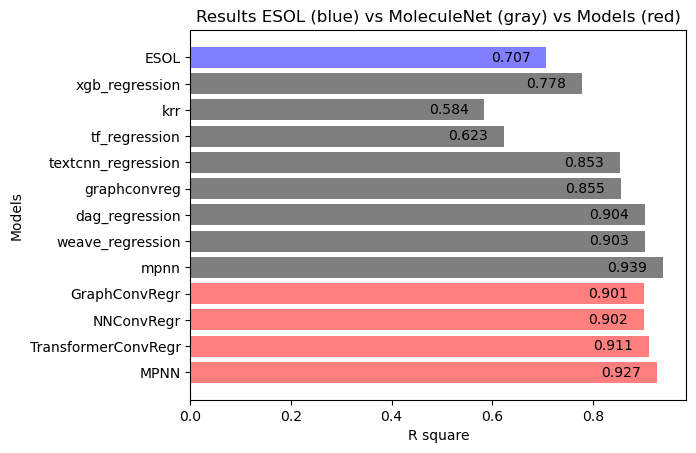

Done!


In [95]:
# Plot Results

# Results from MoleculeNet
labels = ['ESOL', 'xgb_regression', 'krr', 'tf_regression', 'textcnn_regression', 'graphconvreg', 'dag_regression', 'weave_regression', 'mpnn']
r2_all = [r2_ESOL, 0.778, 0.584, 0.623, 0.853, 0.855, 0.904, 0.903, 0.939]

# Results from Models above
labels += ['GraphConvRegr', 'NNConvRegr', 'TransformerConvRegr', 'MPNN']
r2_all += [r2_1, r2_2, r2_3, r2_4]

labels = labels[::-1]
r2_all = r2_all[::-1]

# Plotting
fig, ax = plt.subplots()
bars = ax.barh(range(len(labels)), 
               r2_all, 
               tick_label=labels, 
               color=['r' for i in range(4)] + ['k' for j in range(8)] + ['b'],
               alpha=0.5)

ax.bar_label(bars, fmt='%.3f', padding=-40)

plt.title('Results ESOL (blue) vs MoleculeNet (gray) vs Models (red)')
plt.ylabel('Models')
plt.xlabel('R square')
plt.show()

print('Done!')